In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
import polyphase
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.cm import ScalarMappable
from matplotlib import colors

In [6]:
M = [1,1,1,1] 
chi = 3.10*np.ones(int(0.5*4*(4-1)))
# M = [5,5,1,1] 
# chi = [1,0.5,0.5,0.5,0.5,1]

f = lambda x : polyphase.flory_huggins(x, M, chi)
engine = polyphase.PHASE(f,100,4)
engine.compute()

Computation took 137.23s


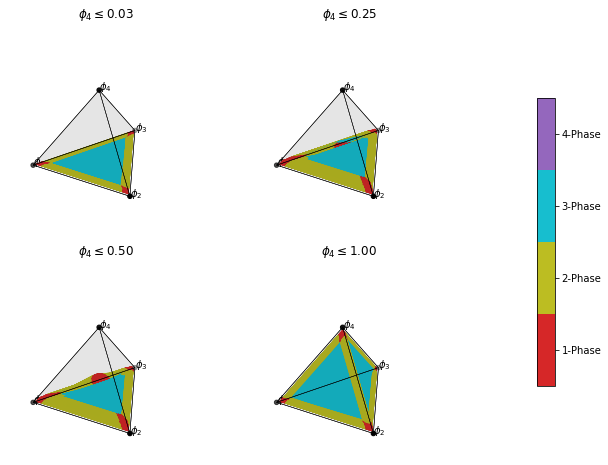

In [7]:
qtplot = polyphase.QuaternaryPlot(engine)
[fig, axs, cbar] = qtplot.show()
plt.show()

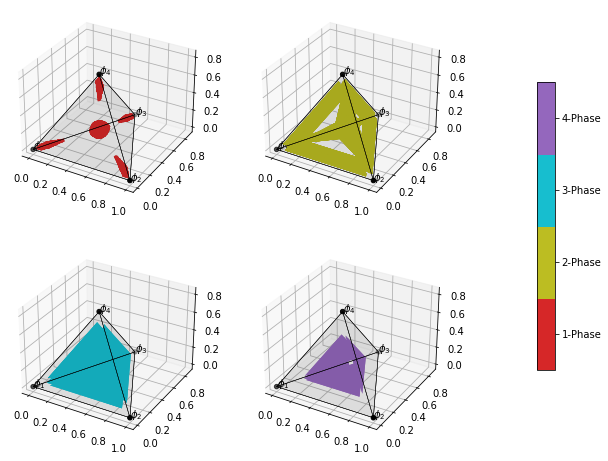

In [8]:
qtplot.plot_simplices()
plt.show()

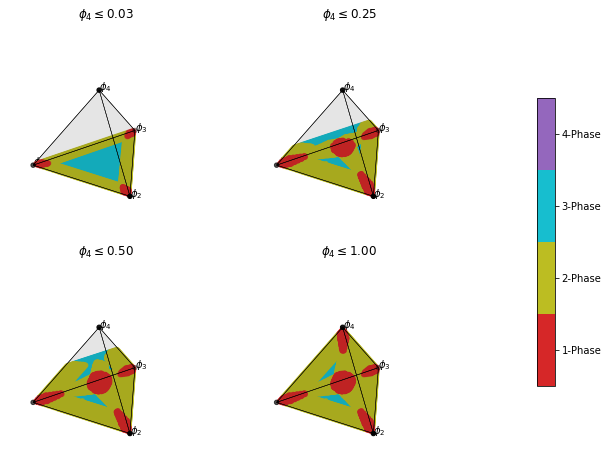

In [9]:
qtplot = polyphase.QuaternaryPlot(engine)
qtplot.show(mode='points')
plt.show()

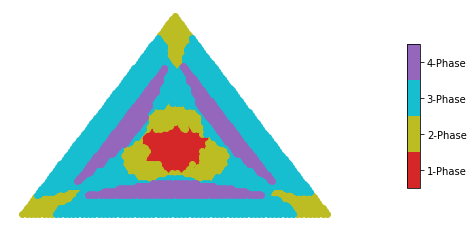

In [49]:
# compare slice from the 4-component system to its equivalent ternary phase diagram
from matplotlib import colors

PHI4 = 0.25
phase_colors =['tab:red','tab:olive','tab:cyan','tab:purple']
cmap = colors.ListedColormap(phase_colors)
fig, ax = plt.subplots()
slice_ids = np.isclose(engine.grid[3,:],PHI4, atol=0.01)
for i in [1,2,3,4]:
    phase_ids = engine.df.T['label']==i
    ids = np.logical_and(slice_ids, phase_ids)
    ax.scatter(qtplot.threed_coords[ids,0],qtplot.threed_coords[ids,1],
               c = phase_colors[int(i-1)])
ax.axis('off')
qtplot.add_colorbar(fig)
plt.show()

## From solvent solubulities

In [29]:
import pandas as pd

solvents = pd.read_pickle('../data/solvents.pkl')
polymers = pd.read_pickle('../data/polymers.pkl')
SMs = pd.read_pickle('../data/SM.pkl')

In [30]:
polymer = polymers[polymers['name']=='PM6']
sm = SMs[SMs['name']=='Y6']
sol1 = solvents[solvents['Solvents']=='Butyl Benzoate']
sol2 = solvents[solvents['Solvents']=='Acetone']

In [31]:
def get_system(polymer, sm, sol1, sol2):
    delta_sol1 = sol1[['dD','dP','dH']].values[0]
    M_sol1 = 1
    M_ref = sol1['MVol'].values[0]
    
    delta_sol2 = sol2[['dD','dP','dH']].values[0]
    M_sol2 = sol2['MVol'].values[0]/M_ref
    
    delta_sm = sm[['dD','dP','dH']].values[0]
    M_sm = (sm['MW'].values[0]/sm['rho'].values[0])*(1/M_ref)
    
    delta_polymer = polymer[['dD','dP','dH']].values[0]
    M_polymer = (polymer['MW'].values[0]/polymer['rho'].values[0])*(1/M_ref)
    
    M = [M_polymer, M_sm, M_sol1, M_sol2]
    chi,inds = polyphase.get_chi_vector([delta_polymer,delta_sm,delta_sol1, delta_sol2], M_ref, approach=2)
    
    return M, chi, inds

M, chi, inds = get_system(polymer, sm, sol1, sol2)

Computation took 192.66s


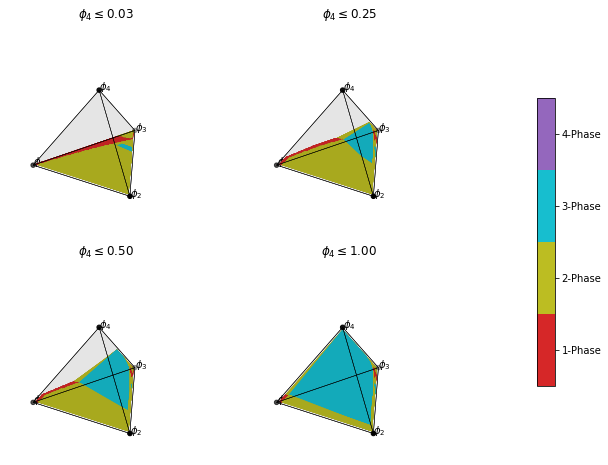

In [32]:
f = lambda x : polyphase.flory_huggins(x, M, chi)
engine = polyphase.PHASE(f,100,4)
engine.compute()
engine.plot()

Computation took 15.06s
(0, 1, 2) [464.360811504688, 5.968755537901413, 1] [0.43597814915972166, 0.5726695408807235, 0.9283784707154958]
Computation took 5.32s
(0, 1, 3) [464.360811504688, 5.968755537901413, 0.41437394722066256] [0.43597814915972166, 4.0967712593208505, 5.295734125754576]
Computation took 16.51s
(0, 2, 3) [464.360811504688, 1, 0.41437394722066256] [0.5726695408807235, 4.0967712593208505, 2.7055379271399915]
Computation took 14.44s
(1, 2, 3) [5.968755537901413, 1, 0.41437394722066256] [0.9283784707154958, 5.295734125754576, 2.7055379271399915]


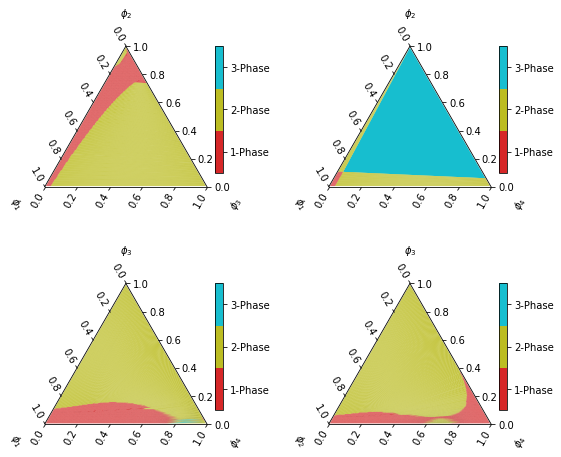

In [34]:
from itertools import combinations
M_inds = list(combinations([0,1,2,3],3))
CHI = polyphase._utri2mat(chi,4)

fig, axs = plt.subplots(2,2,figsize=(8,8),subplot_kw={'projection':'ternary'})
axs = axs.flatten()
fig.subplots_adjust(wspace=0.75,hspace=0.2)
for ax,M_ind in zip(axs,M_inds):
    chi_inds = list(combinations(M_ind,2))
    chi_proj = [CHI[i] for i in chi_inds]
    M_proj = [M[i] for i in M_ind]

    f = lambda x : polyphase.flory_huggins(x, M_proj, chi_proj)
    engine = polyphase.PHASE(f,200,len(M_proj))
    engine.compute()
    
    ternplot = polyphase.TernaryPlot(engine)
    ternplot.plot_simplices(ax=ax, label=False)
    
    ax.set_tlabel(r'$\phi_{}$'.format(M_ind[1]+1))
    ax.set_llabel(r'$\phi_{}$'.format(M_ind[0]+1))
    ax.set_rlabel(r'$\phi_{}$'.format(M_ind[2]+1))

    print(M_ind, M_proj, chi_proj)
    
plt.show()

from IPython import display
import time

qtplot = polyphase.QuaternaryPlot(engine)
for t in np.linspace(0.05,1,num=10):
    qtplot.plot_simplices(sliceat=t)
    display.display(plt.gcf())
    display.clear_output(wait=True)